# Installation des librairies

In [1]:
!pip install -q -q -q tifffile
!pip install -q -q -q tqdm
import os
#quelque-chose
os.chdir('/tf/work/challenge-donnees-sat')

# Lecture des librairies et framework

In [2]:
%load_ext autoreload
%autoreload 2

import s3fs
import shutil

from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
import colorsys
import PIL
from PIL import Image
from tqdm import tqdm
import matplotlib.patches as mpatches
import time

from framework.dataset import LandCoverData as LCD

# Téléchargement + lecture des images de la BDD

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-challengedata-ens/data/additional_files_earthcube_emu4zqr.zip', 'additional_files_earthcube_emu4zqr.zip')
shutil.unpack_archive('additional_files_earthcube_emu4zqr.zip')

# Trainning et Test

In [4]:
DATA_FOLDER_STR = 'dataset'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))

# train

In [8]:
def pixelimage (conca, colimg, colmask):
    
    mask_class = np.empty((0))
    for i in range(colimg.shape[0]):
        for j in range(colimg.shape[1]):
            conca = np.concatenate((conca, [colimg[i][j]]), axis = 0)
            mask_class = np.concatenate((mask_class, [colmask[i][j]]), axis = 0)
            
    conca = np.c_[conca, mask_class]        
    return conca

In [39]:
display_max = 2200
display_min = 0
a = 4
b=0
colimg2=np.empty((0,a))
couleur = np.empty((0,5))
axisconca = 0
start = time.perf_counter()

for k, idx in enumerate(random.sample(range(len(train_images_paths)), 5)):
    axisconca = 0
    image_path = train_images_paths[idx]
    mask_path = train_masks_paths[idx]
    assert image_path.name == mask_path.name
    
    #fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    with TiffFile(image_path) as tif:
        image = tif.asarray()  
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
    image = byte_im
    colimg = byte_im
    with TiffFile(mask_path) as tif :
        colmask = tif.asarray()
        colmask_test = colmask
    
    colimage = pixelimage(colimg2, colimg, colmask)
    
    couleur = np.concatenate((couleur, colimage), axis = 0)
    
    #axs[0].axis("off")
    #im = axs[0].imshow(image)
    #classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
    #show_mask = np.empty((*colmask.shape, 3))
    #classes = LCD.CLASSES
    #for c, color in classes_colorpalette.items():
     #   show_mask[colmask == c, :] = color
        
    #axs[1].axis("off")
    #im = axs[1].imshow(show_mask)
    #handles = []
    #for c, color in classes_colorpalette.items():
     #   handles.append(mpatches.Patch(color=color, label=classes[c]))
      #  axs[1].legend(handles=handles)

    #colimage = pixelimage(colimg2, colimg, colmask)
    #colimage


end = time.perf_counter()

print("temps en seconde : ", end - start)

temps en seconde :  33.693927823973354


In [40]:
start = time.perf_counter()
a = 4
axisconca = 0
no_data = np.empty((0,a))
clouds = np.empty((0,a))
artificial = np.empty((0,a))
cultivated = np.empty((0,a))
broadleaf = np.empty((0,a))
coniferous = np.empty((0,a))
herbaceous = np.empty((0,a))
natural = np.empty((0,a))
snow = np.empty((0,a))
water = np.empty((0,a))


couleur_moy = np.mean(couleur, axis =0)
E_couleur = np.nanstd(couleur, axis = 0)
    
couleur_train = (couleur-couleur_moy)/E_couleur

for i in range (couleur.shape[0]):
    if couleur[i][4] == 0 :
        no_data = np.concatenate((no_data,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [0,0,0]
    if couleur[i][4] == 1 :
        clouds  = np.concatenate((clouds,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [255,25,236]
    if couleur[i][4] == 2 :
        artificial  = np.concatenate((artificial,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [215,25,28]
    if couleur[i][4] == 3 :
        cultivated  = np.concatenate((cultivated,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [211,154,92]
    if couleur[i][4] == 4 :
        broadleaf  = np.concatenate((broadleaf,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [33,115,55]
    if couleur[i][4] == 5 :
        coniferous  = np.concatenate((coniferous,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [21,75,35]
    if couleur[i][4] == 6 :
        herbaceous  = np.concatenate((herbaceous,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [118,209,93]
    if couleur[i][4] == 7 :
        natural  = np.concatenate((natural,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [130,130,130]
    if couleur[i][4] == 8 :
        snow  = np.concatenate((snow,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [255,255,255]
    if couleur[i][4] == 9 :
        water  = np.concatenate((water,[couleur_train[i, 0:4]]), axis = axisconca)
        #colmask_test[i][j] == [43,61,255]
    

end = time.perf_counter()

print("temps en seconde : ", end - start)

temps en seconde :  37.04220338299638


In [41]:
print("no_data    :",np.sum(np.mean(no_data, axis=0)))
print("clouds     :",np.sum(np.mean(clouds, axis=0)))
print("artificial :",np.sum(np.mean(artificial, axis=0)))
print("cultivated :",np.sum(np.mean(cultivated, axis=0)))
print("broadleaf  :",np.sum(np.mean(broadleaf, axis=0)))
print("coniferous :",np.sum(np.mean(coniferous, axis=0)))
print("herbaceous :",np.sum(np.mean(herbaceous, axis=0)))
print("natural    :",np.sum(np.mean(natural, axis=0)))
print("snow       :",np.sum(np.mean(snow, axis=0)))
print("water      :",np.sum(np.mean(water, axis=0)))
print()
print()
print("no_data    :",np.mean(no_data))
print("clouds     :",np.mean(clouds))
print("artificial :",np.mean(artificial))
print("cultivated :",np.mean(cultivated))
print("broadleaf  :",np.mean(broadleaf))
print("coniferous :",np.mean(coniferous))
print("herbaceous :",np.mean(herbaceous))
print("natural    :",np.mean(natural))
print("snow       :",np.mean(snow))
print("water      :",np.mean(water))

no_data    : nan
clouds     : nan
artificial : 2.362543920989071
cultivated : 1.9005510350273567
broadleaf  : -2.8567131043774383
coniferous : -3.32975415739008
herbaceous : -0.6040928384597488
natural    : 6.9039931409050075
snow       : nan
water      : -9.12844509993837


no_data    : nan
clouds     : nan
artificial : 0.5906359802472886
cultivated : 0.47513775875686753
broadleaf  : -0.714178276094366
coniferous : -0.8324385393475191
herbaceous : -0.1510232096149501
natural    : 1.7259982852262534
snow       : nan
water      : -2.282111274984578


In [88]:

no_data_moy = np.mean(no_data)
clouds_moy = np.mean(clouds)
artificial_moy = np.mean(artificial)
cultivated_moy = np.mean(cultivated)
broadleaf_moy = np.mean(broadleaf)
coniferous_moy = np.mean(coniferous)
herbaceous_moy = np.mean(herbaceous)
natural_moy = np.mean(natural)
snow_moy = np.mean(snow)
water_moy = np.mean(water)
train = np.transpose(([['no_data','clouds','artificial','cultivated','broadleaf','coniferous','herbaceous','natural','snow','water'],[no_data_moy,clouds_moy, artificial_moy, cultivated_moy, broadleaf_moy, coniferous_moy, herbaceous_moy, natural_moy, snow_moy, water_moy]]))

In [51]:
train

array([['no_data', 'nan'],
       ['clouds', 'nan'],
       ['artificial', '0.5906359802472886'],
       ['cultivated', '0.47513775875686753'],
       ['broadleaf', '-0.714178276094366'],
       ['coniferous', '-0.8324385393475191'],
       ['herbaceous', '-0.1510232096149501'],
       ['natural', '1.7259982852262534'],
       ['snow', 'nan'],
       ['water', '-2.282111274984578']], dtype='<U19')

# TEST DU TRAIN

no_data_test 0                no_data_test 0
clouds_test     : 0           clouds_test     : 0
artificial_test : 4836        artificial_test : 3235
cultivated_test : 4108       cultivated_test : 7419
broadleaf_test  : 8831       broadleaf_test  : 48265
coniferous_test : 183        coniferous_test : 1445
herbaceous_test : 41385       herbaceous_test : 5172
natural_test    : 6071        natural_test    : 0
snow_test       : 0           snow_test       : 0
water_test      : 122         water_test      : 0
temps en seconde :  15.560423951013945


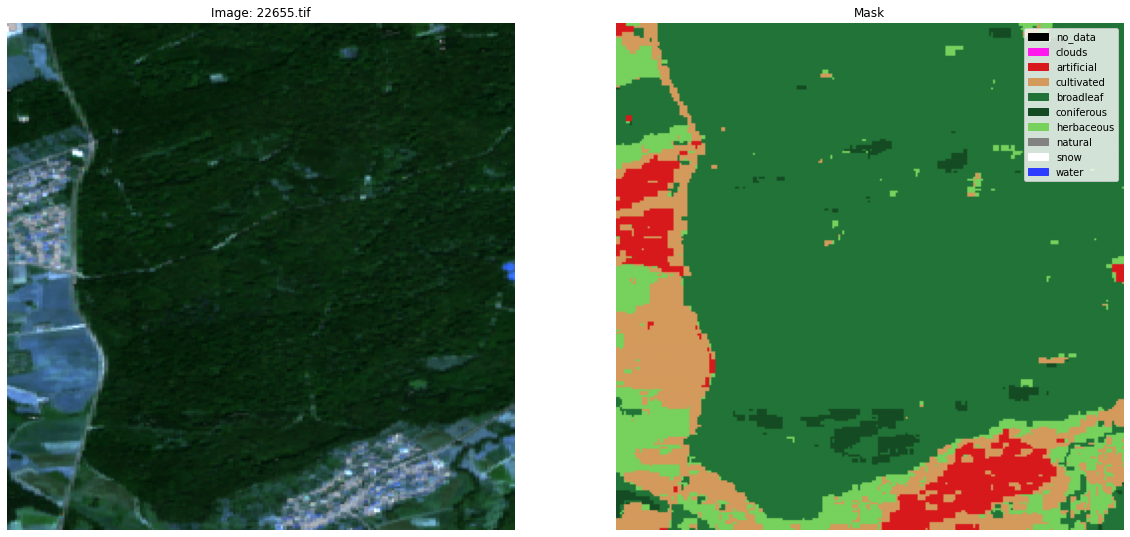

In [103]:
start = time.perf_counter()
a=0
rien_tot = np.empty((0,a))
count =0
display_max = 2200
display_min = 0
for k, idx in enumerate(random.sample(range(len(train_images_paths)), 1)):
    axisconca = 0
    image_path = train_images_paths[idx]
    mask_path = train_masks_paths[idx]
    assert image_path.name == mask_path.name
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    with TiffFile(image_path) as tif:
        image = tif.asarray()  
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
    image = byte_im
    colimg = byte_im
    with TiffFile(mask_path) as tif :
        colmask = tif.asarray()
        colmask_test = colmask
    
    colimage = pixelimage(colimg2, colimg, colmask)
    
    couleur = np.concatenate((couleur, colimage), axis = 0)
    test= couleurtest(image)
    test_sum = np.mean(test, axis=1)
    Resul = pixel(train, test_sum)
    axs[0].axis("off")
    im = axs[0].imshow(image)
    classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
    show_mask = np.empty((*colmask.shape, 3))
    classes = LCD.CLASSES
    for c, color in classes_colorpalette.items():
        show_mask[colmask == c, :] = color
        
    axs[1].axis("off")
    axs[0].set_title(f'Image: {image_path.name}')
    axs[1].set_title('Mask')
    im = axs[1].imshow(show_mask)
    handles = []
    for c, color in classes_colorpalette.items():
        handles.append(mpatches.Patch(color=color, label=classes[c]))
        axs[1].legend(handles=handles)


no_data_test = np.count_nonzero(Resul == 0)
clouds_test = np.count_nonzero(Resul == 1)
artificial_test = np.count_nonzero(Resul ==2)
cultivated_test = np.count_nonzero(Resul == 3)
broadleaf_test = np.count_nonzero(Resul == 4)
coniferous_test = np.count_nonzero(Resul == 5)
herbaceous_test = np.count_nonzero(Resul == 6)
natural_test = np.count_nonzero(Resul == 7)
snow_test = np.count_nonzero(Resul == 8)
water_test = np.count_nonzero(Resul == 9)
no_data_colmask = np.count_nonzero(colmask == 0)
clouds_colmask = np.count_nonzero(colmask == 1)
artificial_colmask = np.count_nonzero(colmask ==2)
cultivated_colmask = np.count_nonzero(colmask == 3)
broadleaf_colmask = np.count_nonzero(colmask == 4)
coniferous_colmask = np.count_nonzero(colmask == 5)
herbaceous_colmask = np.count_nonzero(colmask == 6)
natural_colmask = np.count_nonzero(colmask == 7)
snow_colmask = np.count_nonzero(colmask == 8)
water_colmask = np.count_nonzero(colmask == 9)

print("no_data_test", no_data_test, "               no_data_test", no_data_colmask)
print("clouds_test     :", clouds_test, "          clouds_test     :", clouds_colmask)
print("artificial_test :",artificial_test, "       artificial_test :",artificial_colmask)
print("cultivated_test :",cultivated_test, "      cultivated_test :",cultivated_colmask)
print("broadleaf_test  :",broadleaf_test, "      broadleaf_test  :",broadleaf_colmask)
print("coniferous_test :",coniferous_test, "       coniferous_test :",coniferous_colmask)
print("herbaceous_test :",herbaceous_test, "      herbaceous_test :",herbaceous_colmask)
print("natural_test    :",natural_test, "       natural_test    :",natural_colmask)
print("snow_test       :",snow_test, "          snow_test       :",snow_colmask)
print("water_test      :",water_test, "        water_test      :",water_colmask)

end = time.perf_counter()
print("temps en seconde : ", end - start)

In [37]:
print(np.mean(water))
print(np.mean(water, axis =0))
print(np.sum(np.mean(water, axis =0)))

-2.4631491623762316
[  0.29109597   0.17171073  -0.30025433 -10.01514902]
-9.852596649504907


# Test

In [84]:
def couleurtest(image):
    colimg= np.array(image)
    a=4
    RGB = np.empty((0,a))
    
    #pixel = colimg.shape[0]*colimg.shape[1]
    for i in range(colimg.shape[0]):
        for j in range(colimg.shape[1]):
            RGB = np.concatenate((RGB,[colimg[i][j]]), axis = 0)
            
    RGB_moy = np.nanmean(RGB,axis=0)
    E_RGB = np.nanstd(RGB, axis = 0)
    
    RGB_test = (RGB-RGB_moy)/E_RGB
    return RGB_test
def pixel(train, test):
    pixel = []
    for i in range(test.shape[0]):
        train_ = train[:,1].astype(np.float)
        b = (train_-test[i])
        c= abs(b)
        pixel_= np.nanargmin(c)
        pixel = np.concatenate((pixel, [pixel_]))
    return pixel
    Resul = pixel(train, test_sum)

In [80]:
a = train[:,1].astype(np.float)
b = a - test_sum[0]
b

array([        nan,         nan, -0.8349381 , -0.95043632, -2.13975235,
       -2.25801262, -1.57659729,  0.30042421,         nan, -3.70768535])

TypeError: 'numpy.ndarray' object is not callable

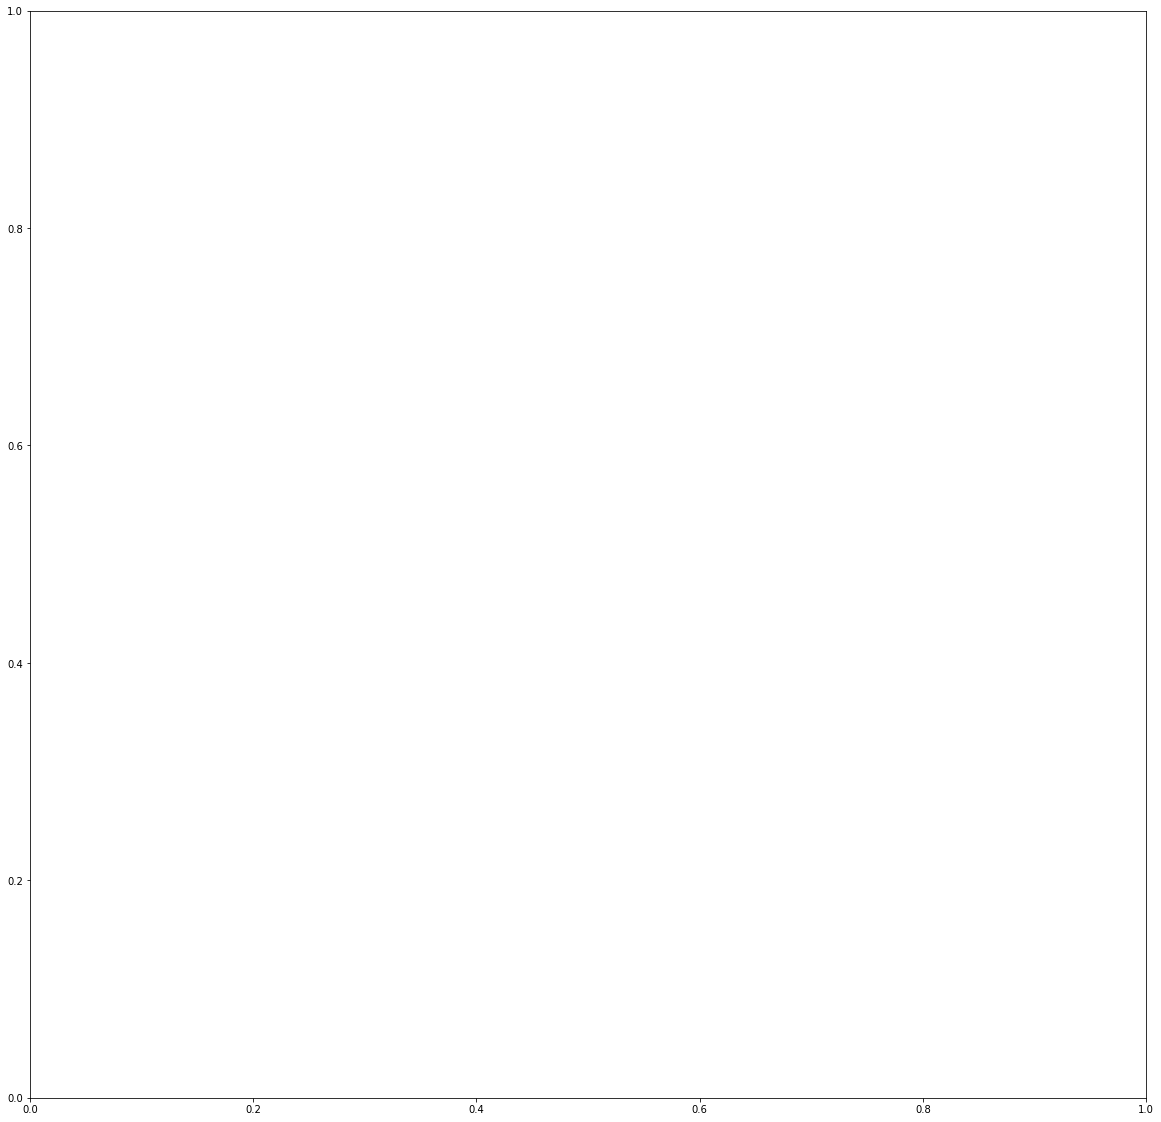

In [83]:
start = time.perf_counter()
a=0
rien_tot = np.empty((0,a))
count =0
display_max = 2200
display_min = 0
for k, idx in enumerate(random.sample(range(len(test_images_paths)), 1)):
    axisconca = 0
    image_path = test_images_paths[idx]
       
    fig, axs = plt.subplots(1, 1, figsize=(20, 20))
    
    with TiffFile(image_path) as tif:
        image = tif.asarray()  
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
    image = byte_im
    test= couleurtest(image)
    test_sum = np.sum(test, axis=1)
    Resul = pixel(train, test_sum)
    axs.axis("off")
    im = axs.imshow(image)
    
end = time.perf_counter()

print("temps en seconde : ", end - start)

In [33]:
no_data_test = np.count_nonzero(Resul == 0)
clouds_test = np.count_nonzero(Resul == 1)
artificial_test = np.count_nonzero(Resul ==2)
cultivated_test = np.count_nonzero(Resul == 3)
broadleaf_test = np.count_nonzero(Resul == 4)
coniferous_test = np.count_nonzero(Resul == 5)
herbaceous_test = np.count_nonzero(Resul == 6)
natural_test = np.count_nonzero(Resul == 7)
snow_test = np.count_nonzero(Resul == 8)
water_test = np.count_nonzero(Resul == 9)

print("no_data_test", no_data_test)
print("clouds_test     :", clouds_test)
print("artificial_test :",artificial_test)
print("cultivated_test :",cultivated_test)
print("broadleaf_test  :",broadleaf_test)
print("coniferous_test :",coniferous_test)
print("herbaceous_test :",herbaceous_test)
print("natural_test    :",natural_test)
print("snow_test       :",snow_test)
print("water_test      :",water_test)

no_data_test 0
clouds_test     : 2566
artificial_test : 2553
cultivated_test : 3094
broadleaf_test  : 7992
coniferous_test : 18592
herbaceous_test : 8143
natural_test    : 10571
snow_test       : 0
water_test      : 12025


In [97]:
print(list(zip(*np.where(Resul ==1))))

[(14,), (23,), (24,), (270,), (442,), (443,), (556,), (557,), (693,), (694,), (696,), (697,), (698,), (699,), (812,), (813,), (949,), (950,), (952,), (953,), (1210,), (1211,), (1212,), (1720,), (1721,), (1722,), (1723,), (1724,), (1729,), (1980,), (1981,), (1982,), (1985,), (2537,), (2538,), (2812,), (2813,), (2815,), (3068,), (3069,), (3070,), (3071,), (3324,), (3325,), (3326,), (3327,), (3582,), (3583,), (3835,), (3836,), (3837,), (4091,), (6284,), (6540,), (7047,), (7048,), (7049,), (7050,), (7051,), (7374,), (7379,), (7625,), (7626,), (7633,), (7634,), (7815,), (7816,), (7823,), (7824,), (7891,), (8071,), (8072,), (8077,), (8078,), (8079,), (8080,), (8086,), (8144,), (8145,), (8146,), (8147,), (8327,), (8328,), (8332,), (8392,), (8396,), (8397,), (8401,), (8402,), (8403,), (8652,), (8653,), (8654,), (8655,), (8789,), (8790,), (8791,), (9164,), (9165,), (9171,), (10370,), (10371,), (10626,), (10627,), (11155,), (11419,), (12816,), (12817,), (12818,), (12821,), (12822,), (13079,), (1

In [85]:
test_sum[5]

2.6954610479086654

# Test d'un réseau de neuronnes avec une seule couche. 

In [22]:
# Nous avons des images en 256*256 pixels, soit 65 536 pixels par images avec 10 classes différentes, soit 655 360 paramètres pour la première couche du réseau de neuronnes.
# Pour ce faire, nous allons créer 10 filtres unicolores pour chaque classes. A savoir, nos images comportent 4 couleurs : Rouge, vert, bleu mais aussi spectroscopie dans l'infrarouge proche SPIR.
# Dans ce premier cas, on ne prendra pas en compte le SPIR mais uniquement le spectre du visible. 
# P : matrice de pixels 246*256 soit 1*65 536
# W : matrices filtres de tailles 65 536 * 10
# S : matrices de 1*10 allant de 0 à 1 (pourcentage de classe) => sum(S) = 1
# 
# De ce fait, lors de la phase de test, l'inconnue dans notre opération est W, notre matric de filtre.
# Pour trouver la valeur de la matrixe W, on tentera de miimiser notre erreur E:
# E = sum((P.W-S)²)                   => pour les dimension des matrices :  sum (((1 * 65 536 . 65 536 * 10) - 1*10)²)
# Si E = 0, on aura trouver le filtre le plus proche possible pour passer de notre image satellite au mask que nous appliquons. 
# Pour nous approcher de E = 0, nous allons donc devoir faire varier notre filtre W. Pour ce faire, on utilisera le gradient de W. Soit 
# W(i+1 ) = W(i) - f'(W(i)) * fac     avec fac proche de 0 pour le faire varier petit à petit. 
# Le gradient de W est  : Grad = t(P)*(2*(P.W-S))    avec t(P) la transposé de la matrice P

In [ ]:
# les 10 classes en RGB et hexa
# No-data => 0;0;0      FFFFFF
# Clouds => 255;25;23   FF19EC
# Artificial surfaces and constructions => 215;25;28   D7191C
# Cultivated ares => 211;154;92   D39A5C
# broadleaf tree cover => 33;115;55   217337
# Coniferous tree vover => 21;75;35   154B23
# Herbaceous vegetation => 118;209;93   76D15D
# Natural material surfaces => 130;130;130   828282
# Permanent snow-covered surfaces => 255;255;255   FFFFFF
# Water bodies => 43;61;255   2B3DFF

In [ ]:
a = 4
    no_data = np.empty((0,a))
    clouds = np.empty((0,a))
    artificial = np.empty((0,a))
    cultivated = np.empty((0,a))
    broadleaf = np.empty((0,a))
    coniferous = np.empty((0,a))
    herbaceous = np.empty((0,a))
    natural = np.empty((0,a))
    snow = np.empty((0,a))
    water = np.empty((0,a))
    axisconca = 0
    
    
    
no_data_tot_moy = np.nanmean(no_data_moy_tot,axis=0)
clouds_tot_moy = np.nanmean(clouds_moy_tot, axis=0)
artificial_tot_moy = np.nanmean(artificial_moy_tot, axis=0)
cultivated_tot_moy = np.nanmean(cultivated_moy_tot, axis=0)
broadleaf_tot_moy = np.nanmean(broadleaf_moy_tot, axis=0)
coniferous_tot_moy = np.nanmean(coniferous_moy_tot, axis=0)
herbaceous_tot_moy = np.nanmean(herbaceous_moy_tot, axis=0)
natural_tot_moy = np.nanmean(natural_moy_tot, axis=0)
snow_tot_moy = np.nanmean(snow_moy_tot, axis=0)
water_tot_moy = np.nanmean(water_moy_tot, axis=0)